<a href="https://colab.research.google.com/github/AronPerez/CS4933_Project/blob/corey/CV_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial 

## Aarons workspace

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Configs

In [2]:
!pip install scipy==1.1.0

In [11]:
import sys
import time
import os
import random
import numpy as np
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import pickle
import glob
import matplotlib.pyplot as plt
from PIL import Image
from scipy.misc import imread
from abc import abstractmethod
from __future__ import print_function
from torchsummary import summary
import torch
import platform

In [ ]:
# Prompt for input
name = input("Select a model name ")
while True:
  dataset = input("Select a dataset, either places365_dataset or cifar10_dataset ")
  if "PLACES365" in dataset.upper():
    dataset = 'PLACE365_DATASET'
    dataset_path = './dataset/places365'
    break
  elif 'CIFAR10' in dataset.upper():
    dataset = 'CIFAR10_DATASET'
    dataset_path = '/content/drive/MyDrive/CV/cifar10'
    break
  else:
    print("Invalid dataset")
  
batch_size = int(input("Please select a batch size "))

options = {
    "seed": 100,
    "beta1": 0.0,
    "name": name.upper(),
    "mode": 0,
    "dataset": dataset,
    "dataset_path": dataset_path,
    "checkpoints_path": '/content/drive/MyDrive/CV/checkpoints',
    "color_space": 'lab',
    "batch_size": batch_size,
    "epochs": 10,
    "l1_weight": 100.0,
    "lr": 3e-4,
    "lr_decay": True,
    "lr_decay_rate": 0.1,
    "lr_decay_steps": 1e4,
    "augment": True,
    "acc_thresh": 2.0,
    "gpu_ids": 0,
    "save": True,
    "save_interval": 1000,
    "sample": True,
    "sample_size": 8,
    "sample_interval": 1000,
    "validate": True,
    "validate_interval": 10000,
    "log": True,
    "log_interval": 834,
    "visualize": True,
    "visualize_window": 100,
    "test_input": '',
    "test_output": '',
    "turing_test_size": 100,
    "turing_test_delay": 0,
    "label_smoothing": 1,
    "training": True
}

Select a model name ETF
Select a dataset, either places365_dataset or cifar10_dataset cifar10_dataset 
Please select a batch size 60


### Dataset

In [4]:
CIFAR10_DATASET = 'cifar10'
PLACES365_DATASET = 'places365'

In [7]:
class BaseDataset():
    def __init__(self, name, path, training=True, augment=True):
        self.name = name
        self.augment = augment and training
        self.training = training
        self.path = path
        self._data = []

    def __len__(self):
        return len(self.data)

    def __iter__(self):
        total = len(self)
        start = 0

        while start < total:
            item = self[start]
            start += 1
            yield item
        print("You're over here")
        raise StopIteration

    def __getitem__(self, index):
        val = self.data[index]
        try:
            img = imread(val) if isinstance(val, str) else val

            # grayscale images
            if np.sum(img[:,:,0] - img[:,:,1]) == 0 and np.sum(img[:,:,0] - img[:,:,2]) == 0:
                return None

            if self.augment and np.random.binomial(1, 0.5) == 1:
                img = img[:, ::-1, :]

        except:
            img = None

        return img

    def generator(self, batch_size, recusrive=False):
        start = 0
        total = len(self)

        while True:
            while start < total:
                end = np.min([start + batch_size, total])
                items = []

                for ix in range(start, end):
                    item = self[ix]
                    if item is not None:
                        items.append(item)

                start = end
                yield items

            if recusrive:
                start = 0

            else:
                #print("Where am I?")
                return items

    @property
    def data(self):
        if len(self._data) == 0:
            self._data = self.load()
            np.random.shuffle(self._data)

        return self._data

    @abstractmethod
    def load(self):
        return []

In [9]:
class Cifar10Dataset(BaseDataset):
    def __init__(self, path, training=True, augment=True):
        super(Cifar10Dataset, self).__init__(CIFAR10_DATASET, path, training, augment)

    def load(self):
        data = []
        if self.training:
            for i in range(1, 6):
                filename = '{}/data_batch_{}'.format(self.path, i)
                batch_data = unpickle(filename)
                if len(data) > 0:
                    data = np.vstack((data, batch_data[b'data']))
                else:
                    data = batch_data[b'data']

        else:
            filename = '{}/test_batch'.format(self.path)
            batch_data = unpickle(filename)
            data = batch_data[b'data']

        w = 32
        h = 32
        s = w * h
        data = np.array(data)
        data = np.dstack((data[:, :s], data[:, s:2 * s], data[:, 2 * s:]))
        data = data.reshape((-1, w, h, 3))
        return data

### Helper

In [ ]:
def str2bool(v):
    if v.lower() in ('yes', 'true', 't', 'y', '1'):
        return True
    elif v.lower() in ('no', 'false', 'f', 'n', '0'):
        return False
    else:
        raise ('Boolean value expected.')

In [ ]:
def parse(input):
  opt = input
  os.environ['CUDA_VISIBLE_DEVICES'] = opt.gpu_ids
  opt.color_space = opt.color_space.upper()
  opt.training = opt.mode == 1

  if opt.seed == 0:
    opt.seed = random.randint(0, 2**31 - 1)

  if opt.dataset_path == './dataset':
    opt.dataset_path += ('/' + opt.dataset)

  if opt.checkpoints_path == './checkpoints':
    opt.checkpoints_path += ('/' + opt.dataset)

    return opt

### Utils

In [ ]:
def stitch_images(grayscale, original, pred):
    gap = 5
    width, height = original[0][:, :, 0].shape
    img_per_row = 2 if width > 200 else 4
    img = Image.new('RGB', (width * img_per_row * 3 + gap * (img_per_row - 1), height * int(len(original) / img_per_row)))

    grayscale = np.array(grayscale).squeeze()
    original = np.array(original)
    pred = np.array(pred)

    for ix in range(len(original)):
        xoffset = int(ix % img_per_row) * width * 3 + int(ix % img_per_row) * gap
        yoffset = int(ix / img_per_row) * height
        im1 = Image.fromarray(grayscale[ix])
        im2 = Image.fromarray(original[ix])
        im3 = Image.fromarray((pred[ix] * 255).astype(np.uint8))
        img.paste(im1, (xoffset, yoffset))
        img.paste(im2, (xoffset + width, yoffset))
        img.paste(im3, (xoffset + width + width, yoffset))

    return img


In [ ]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

    return dir

In [ ]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
def moving_average(data, window_width):
    cumsum_vec = np.cumsum(np.insert(data, 0, 0))
    ma_vec = (cumsum_vec[window_width:] - cumsum_vec[:-window_width]) / window_width
    return ma_vec

In [ ]:
def imshow(img, title=''):
    fig = plt.gcf()
    fig.canvas.set_window_title(title)
    plt.axis('off')
    plt.imshow(img, interpolation='none')
    plt.show()

In [ ]:
def imsave(img, path):
    im = Image.fromarray(np.array(img).astype(np.uint8).squeeze())
    im.save(path)

In [ ]:
def turing_test(real_img, fake_img, delay=0):
    height, width, _ = real_img.shape
    imgs = np.array([real_img, (fake_img * 255).astype(np.uint8)])
    real_index = np.random.binomial(1, 0.5)
    fake_index = (real_index + 1) % 2

    img = Image.new('RGB', (2 + width * 2, height))
    img.paste(Image.fromarray(imgs[real_index]), (0, 0))
    img.paste(Image.fromarray(imgs[fake_index]), (2 + width, 0))

    img.success = 0

    def onclick(event):
        if event.xdata is not None:
            if event.x < width and real_index == 0:
                img.success = 1

            elif event.x > width and real_index == 1:
                img.success = 1

        plt.gcf().canvas.stop_event_loop()

    plt.ion()
    plt.gcf().canvas.mpl_connect('button_press_event', onclick)
    plt.title('click on the real image')
    plt.axis('off')
    plt.imshow(img, interpolation='none')
    plt.show()
    plt.draw()
    plt.gcf().canvas.start_event_loop(delay)

    return img.success

In [10]:
def visualize(train_log_file, test_log_file, window_width, title=''):
    train_data = np.loadtxt(train_log_file)
    test_data = np.loadtxt(test_log_file)

    if len(train_data.shape) < 2:
        return

    if len(train_data) < window_width:
        window_width = len(train_data) - 1

    fig = plt.gcf()
    fig.canvas.set_window_title(title)

    plt.ion()
    plt.subplot('121')
    plt.cla()
    if len(train_data) > 1:
        plt.plot(moving_average(train_data[:, 8], window_width))
    plt.title('train')

    plt.subplot('122')
    plt.cla()
    if len(test_data) >= 1:
        plt.plot(moving_average(test_data[:, 8], window_width))
    plt.title('test')

    plt.show()
    plt.draw()
    plt.pause(.01)

### Ops

In [ ]:
COLORSPACE_RGB = 'RGB'
COLORSPACE_LAB = 'LAB'
#tf.nn.softmax_cross_entropy_with_logits_v2

In [ ]:
def conv2d(inputs, filters, name, kernel_size=4, strides=2, bnorm=True, activation=None, seed=None):
    """
    Creates a conv2D block
    """
    initializer=tf.variance_scaling_initializer(seed=seed)
    res = tf.layers.conv2d(
        name=name,
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer=initializer)

    if bnorm:
        res = tf.layers.batch_normalization(inputs=res, name='bn_' + name, training=True)

    # activation after batch-norm
    if activation is not None:
        res = activation(res)

    return res

In [ ]:
def conv2d_transpose(inputs, filters, name, kernel_size=4, strides=2, bnorm=True, activation=None, seed=None):
    """
    Creates a conv2D-transpose block
    """
    initializer=tf.variance_scaling_initializer(seed=seed)
    res = tf.layers.conv2d_transpose(
        name=name,
        inputs=inputs,
        filters=filters,
        kernel_size=kernel_size,
        strides=strides,
        padding="same",
        kernel_initializer=initializer)

    if bnorm:
        res = tf.layers.batch_normalization(inputs=res, name='bn_' + name, training=True)

    # activation after batch-norm
    if activation is not None:
        res = activation(res)

    return res

In [ ]:
def pixelwise_accuracy(img_real, img_fake, colorspace, thresh):
    """
    Measures the accuracy of the colorization process by comparing pixels
    """
    img_real = postprocess(img_real, colorspace, COLORSPACE_LAB)
    img_fake = postprocess(img_fake, colorspace, COLORSPACE_LAB)

    diffL = tf.abs(tf.round(img_real[..., 0]) - tf.round(img_fake[..., 0]))
    diffA = tf.abs(tf.round(img_real[..., 1]) - tf.round(img_fake[..., 1]))
    diffB = tf.abs(tf.round(img_real[..., 2]) - tf.round(img_fake[..., 2]))

    # within %thresh of the original
    predL = tf.cast(tf.less_equal(diffL, 1 * thresh), tf.float64)        # L: [0, 100]
    predA = tf.cast(tf.less_equal(diffA, 2.2 * thresh), tf.float64)      # A: [-110, 110]
    predB = tf.cast(tf.less_equal(diffB, 2.2 * thresh), tf.float64)      # B: [-110, 110]

    # all three channels are within the threshold
    pred = predL * predA * predB

    return tf.reduce_mean(pred)

In [ ]:
def preprocess(img, colorspace_in, colorspace_out):
    if colorspace_out.upper() == COLORSPACE_RGB:
        if colorspace_in == COLORSPACE_LAB:
            img = lab_to_rgb(img)

        # [0, 1] => [-1, 1]
        img = (img / 255.0) * 2 - 1

    elif colorspace_out.upper() == COLORSPACE_LAB:
        if colorspace_in == COLORSPACE_RGB:
            img = rgb_to_lab(img / 255.0)

        L_chan, a_chan, b_chan = tf.unstack(img, axis=3)

        # L: [0, 100] => [-1, 1]
        # A, B: [-110, 110] => [-1, 1]
        img = tf.stack([L_chan / 50 - 1, a_chan / 110, b_chan / 110], axis=3)

    return img

In [ ]:
def postprocess(img, colorspace_in, colorspace_out):
    if colorspace_in.upper() == COLORSPACE_RGB:
        # [-1, 1] => [0, 1]
        img = (img + 1) / 2

        if colorspace_out == COLORSPACE_LAB:
            img = rgb_to_lab(img)

    elif colorspace_in.upper() == COLORSPACE_LAB:
        L_chan, a_chan, b_chan = tf.unstack(img, axis=3)

        # L: [-1, 1] => [0, 100]
        # A, B: [-1, 1] => [-110, 110]
        img = tf.stack([(L_chan + 1) / 2 * 100, a_chan * 110, b_chan * 110], axis=3)

        if colorspace_out == COLORSPACE_RGB:
            img = lab_to_rgb(img)

    return img

In [ ]:
def rgb_to_lab(srgb):
    # based on https://github.com/torch/image/blob/9f65c30167b2048ecbe8b7befdc6b2d6d12baee9/generic/image.c
    with tf.name_scope("rgb_to_lab"):
        srgb_pixels = tf.reshape(srgb, [-1, 3])

        with tf.name_scope("srgb_to_xyz"):
            linear_mask = tf.cast(srgb_pixels <= 0.04045, dtype=tf.float32)
            exponential_mask = tf.cast(srgb_pixels > 0.04045, dtype=tf.float32)
            rgb_pixels = (srgb_pixels / 12.92 * linear_mask) + (((srgb_pixels + 0.055) / 1.055) ** 2.4) * exponential_mask
            rgb_to_xyz = tf.constant([
                #    X        Y          Z
                [0.412453, 0.212671, 0.019334],  # R
                [0.357580, 0.715160, 0.119193],  # G
                [0.180423, 0.072169, 0.950227],  # B
            ])
            xyz_pixels = tf.matmul(rgb_pixels, rgb_to_xyz)

        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope("xyz_to_cielab"):

            # normalize for D65 white point
            xyz_normalized_pixels = tf.multiply(xyz_pixels, [1 / 0.950456, 1.0, 1 / 1.088754])

            epsilon = 6 / 29
            linear_mask = tf.cast(xyz_normalized_pixels <= (epsilon**3), dtype=tf.float32)
            exponential_mask = tf.cast(xyz_normalized_pixels > (epsilon**3), dtype=tf.float32)
            fxfyfz_pixels = (xyz_normalized_pixels / (3 * epsilon**2) + 4 / 29) * linear_mask + (xyz_normalized_pixels ** (1 / 3)) * exponential_mask

            # convert to lab
            fxfyfz_to_lab = tf.constant([
                #  l       a       b
                [0.0, 500.0, 0.0],  # fx
                [116.0, -500.0, 200.0],  # fy
                [0.0, 0.0, -200.0],  # fz
            ])
            lab_pixels = tf.matmul(fxfyfz_pixels, fxfyfz_to_lab) + tf.constant([-16.0, 0.0, 0.0])

        return tf.reshape(lab_pixels, tf.shape(srgb))

In [ ]:
def lab_to_rgb(lab):
    with tf.name_scope("lab_to_rgb"):
        lab_pixels = tf.reshape(lab, [-1, 3])

        # https://en.wikipedia.org/wiki/Lab_color_space#CIELAB-CIEXYZ_conversions
        with tf.name_scope("cielab_to_xyz"):
            # convert to fxfyfz
            lab_to_fxfyfz = tf.constant([
                #   fx      fy        fz
                [1 / 116.0, 1 / 116.0, 1 / 116.0],  # l
                [1 / 500.0, 0.0, 0.0],  # a
                [0.0, 0.0, -1 / 200.0],  # b
            ])
            fxfyfz_pixels = tf.matmul(lab_pixels + tf.constant([16.0, 0.0, 0.0]), lab_to_fxfyfz)

            # convert to xyz
            epsilon = 6 / 29
            linear_mask = tf.cast(fxfyfz_pixels <= epsilon, dtype=tf.float32)
            exponential_mask = tf.cast(fxfyfz_pixels > epsilon, dtype=tf.float32)
            xyz_pixels = (3 * epsilon**2 * (fxfyfz_pixels - 4 / 29)) * linear_mask + (fxfyfz_pixels ** 3) * exponential_mask

            # denormalize for D65 white point
            xyz_pixels = tf.multiply(xyz_pixels, [0.950456, 1.0, 1.088754])

        with tf.name_scope("xyz_to_srgb"):
            xyz_to_rgb = tf.constant([
                #     r           g          b
                [3.2404542, -0.9692660, 0.0556434],  # x
                [-1.5371385, 1.8760108, -0.2040259],  # y
                [-0.4985314, 0.0415560, 1.0572252],  # z
            ])
            rgb_pixels = tf.matmul(xyz_pixels, xyz_to_rgb)
            # avoid a slightly negative number messing up the conversion
            rgb_pixels = tf.clip_by_value(rgb_pixels, 0.0, 1.0)
            linear_mask = tf.cast(rgb_pixels <= 0.0031308, dtype=tf.float32)
            exponential_mask = tf.cast(rgb_pixels > 0.0031308, dtype=tf.float32)
            srgb_pixels = (rgb_pixels * 12.92 * linear_mask) + ((rgb_pixels ** (1 / 2.4) * 1.055) - 0.055) * exponential_mask

        return tf.reshape(srgb_pixels, tf.shape(lab))

In [ ]:
class Progbar(object):
    """Displays a progress bar.
    Arguments:
        target: Total number of steps expected, None if unknown.
        width: Progress bar width on screen.
        verbose: Verbosity mode, 0 (silent), 1 (verbose), 2 (semi-verbose)
        stateful_metrics: Iterable of string names of metrics that
            should *not* be averaged over time. Metrics in this list
            will be displayed as-is. All others will be averaged
            by the progbar before display.
        interval: Minimum visual progress update interval (in seconds).
    """

    def __init__(self, target, width=25, verbose=1, interval=0.05,
                 stateful_metrics=None):
        self.target = target
        self.width = width
        self.verbose = verbose
        self.interval = interval
        if stateful_metrics:
            self.stateful_metrics = set(stateful_metrics)
        else:
            self.stateful_metrics = set()

        self._dynamic_display = ((hasattr(sys.stdout, 'isatty') and
                                  sys.stdout.isatty()) or
                                 'ipykernel' in sys.modules or
                                 'posix' in sys.modules)
        self._total_width = 0
        self._seen_so_far = 0
        # We use a dict + list to avoid garbage collection
        # issues found in OrderedDict
        self._values = {}
        self._values_order = []
        self._start = time.time()
        self._last_update = 0

    def update(self, current, values=None):
        """Updates the progress bar.
        Arguments:
            current: Index of current step.
            values: List of tuples:
                `(name, value_for_last_step)`.
                If `name` is in `stateful_metrics`,
                `value_for_last_step` will be displayed as-is.
                Else, an average of the metric over time will be displayed.
        """
        values = values or []
        for k, v in values:
            if k not in self._values_order:
                self._values_order.append(k)
            if k not in self.stateful_metrics:
                if k not in self._values:
                    self._values[k] = [v * (current - self._seen_so_far),
                                       current - self._seen_so_far]
                else:
                    self._values[k][0] += v * (current - self._seen_so_far)
                    self._values[k][1] += (current - self._seen_so_far)
            else:
                self._values[k] = v
        self._seen_so_far = current

        now = time.time()
        info = ' - %.0fs' % (now - self._start)
        if self.verbose == 1:
            if (now - self._last_update < self.interval and
                    self.target is not None and current < self.target):
                return

            prev_total_width = self._total_width
            if self._dynamic_display:
                sys.stdout.write('\b' * prev_total_width)
                sys.stdout.write('\r')
            else:
                sys.stdout.write('\n')

            if self.target is not None:
                numdigits = int(np.floor(np.log10(self.target))) + 1
                barstr = '%%%dd/%d [' % (numdigits, self.target)
                bar = barstr % current
                prog = float(current) / self.target
                prog_width = int(self.width * prog)
                if prog_width > 0:
                    bar += ('=' * (prog_width - 1))
                    if current < self.target:
                        bar += '>'
                    else:
                        bar += '='
                bar += ('.' * (self.width - prog_width))
                bar += ']'
            else:
                bar = '%7d/Unknown' % current

            self._total_width = len(bar)
            sys.stdout.write(bar)

            if current:
                time_per_unit = (now - self._start) / current
            else:
                time_per_unit = 0
            if self.target is not None and current < self.target:
                eta = time_per_unit * (self.target - current)
                if eta > 3600:
                    eta_format = '%d:%02d:%02d' % (eta // 3600,
                                                   (eta % 3600) // 60,
                                                   eta % 60)
                elif eta > 60:
                    eta_format = '%d:%02d' % (eta // 60, eta % 60)
                else:
                    eta_format = '%ds' % eta

                info = ' - ETA: %s' % eta_format
            else:
                if time_per_unit >= 1:
                    info += ' %.0fs/step' % time_per_unit
                elif time_per_unit >= 1e-3:
                    info += ' %.0fms/step' % (time_per_unit * 1e3)
                else:
                    info += ' %.0fus/step' % (time_per_unit * 1e6)

            for k in self._values_order:
                info += ' - %s:' % k
                if isinstance(self._values[k], list):
                    avg = np.mean(self._values[k][0] / max(1, self._values[k][1]))
                    if abs(avg) > 1e-3:
                        info += ' %.4f' % avg
                    else:
                        info += ' %.4e' % avg
                else:
                    info += ' %s' % self._values[k]

            self._total_width += len(info)
            if prev_total_width > self._total_width:
                info += (' ' * (prev_total_width - self._total_width))

            if self.target is not None and current >= self.target:
                info += '\n'

            sys.stdout.write(info)
            sys.stdout.flush()

        elif self.verbose == 2:
            if self.target is None or current >= self.target:
                for k in self._values_order:
                    info += ' - %s:' % k
                    avg = np.mean(self._values[k][0] / max(1, self._values[k][1]))
                    if avg > 1e-3:
                        info += ' %.4f' % avg
                    else:
                        info += ' %.4e' % avg
                info += '\n'

                sys.stdout.write(info)
                sys.stdout.flush()

        self._last_update = now

    def add(self, n, values=None):
        self.update(self._seen_so_far + n, values)

### Model

In [ ]:
class BaseModel:
    def __init__(self, sess, options):
        self.sess = sess
        self.options = options
        self.name = options["name"]
        self.samples_dir = os.path.join(options["checkpoints_path"], 'samples')
        self.test_log_file = os.path.join(options["checkpoints_path"], 'log_test.dat')
        self.train_log_file = os.path.join(options["checkpoints_path"], 'log_train.dat')
        self.global_step = tf.Variable(0, name='global_step', trainable=False)
        self.dataset_train = self.create_dataset(True)
        self.dataset_val = self.create_dataset(False)
        self.sample_generator = self.dataset_val.generator(options["sample_size"], True)
        self.iteration = 0
        self.epoch = 0
        self.is_built = False

    def train(self):
        total = len(self.dataset_train)

        for epoch in range(options["epochs"]):
            lr_rate = self.sess.run(self.learning_rate)

            print('Training epoch: %d' % (epoch + 1) + " - learning rate: " + str(lr_rate))

            self.epoch = epoch + 1
            self.iteration = 0

            generator = self.dataset_train.generator(options["batch_size"])
            progbar = Progbar(total, width=25, stateful_metrics=['epoch', 'iter', 'step'])
    
            for input_rgb in generator:
                feed_dic = {self.input_rgb: input_rgb}

                self.iteration = self.iteration + 1
                self.sess.run([self.dis_train], feed_dict=feed_dic)
                self.sess.run([self.gen_train, self.accuracy], feed_dict=feed_dic)
                self.sess.run([self.gen_train, self.accuracy], feed_dict=feed_dic)

                lossD, lossD_fake, lossD_real, lossG, lossG_l1, lossG_gan, acc, step = self.eval_outputs(feed_dic=feed_dic)

                progbar.add(len(input_rgb), values=[
                    ("epoch", epoch + 1),
                    ("iter", self.iteration),
                    ("step", step),
                    ("D loss", lossD),
                    ("D fake", lossD_fake),
                    ("D real", lossD_real),
                    ("G loss", lossG),
                    ("G L1", lossG_l1),
                    ("G gan", lossG_gan),
                    ("accuracy", acc)
                ])

                # log model at checkpoints
                if options["log"] and step % options["log_interval"] == 0:
                    with open(self.train_log_file, 'a') as f:
                        f.write('%d %d %f %f %f %f %f %f %f\n' % (self.epoch, step, lossD, lossD_fake, lossD_real, lossG, lossG_l1, lossG_gan, acc))

                    if options["visualize"]:
                        visualize(self.train_log_file, self.test_log_file, options["visualize_window"], self.name)

                # sample model at checkpoints
                if options["sample"] and step % options["sample_interval"] == 0:
                    self.sample(show=False)

                # validate model at checkpoints
                if options["validate"] and options["validate_interval"] > 0 and step % options["validate_interval"] == 0:
                    self.validate()

                # save model at checkpoints
                if options["save"] and step % options["save_interval"] == 0:
                    self.save()

            if options["validate"]:
                self.validate()

    def validate(self):
        print('\n\nValidating epoch: %d' % self.epoch)
        total = len(self.dataset_val)
        val_generator = self.dataset_val.generator(options["batch_size"])
        progbar = Progbar(total, width=25)

        for input_rgb in val_generator:
            feed_dic = {self.input_rgb: input_rgb}

            self.sess.run([self.dis_loss, self.gen_loss, self.accuracy], feed_dict=feed_dic)

            lossD, lossD_fake, lossD_real, lossG, lossG_l1, lossG_gan, acc, step = self.eval_outputs(feed_dic=feed_dic)

            progbar.add(len(input_rgb), values=[
                ("D loss", lossD),
                ("D fake", lossD_fake),
                ("D real", lossD_real),
                ("G loss", lossG),
                ("G L1", lossG_l1),
                ("G gan", lossG_gan),
                ("accuracy", acc)
            ])
            with open(self.test_log_file, 'a') as f:
              f.write('%d %d %f %f %f %f %f %f %f\n' % (self.epoch, step, lossD, lossD_fake, lossD_real, lossG, lossG_l1, lossG_gan, acc))

        print('\n')

    def test(self):
        print('\nTesting...')
        dataset = TestDataset(options["test_input"] or (options["checkpoints_path"] + '/test'))
        outputs_path = create_dir(options["test_output"] or (options["checkpoints_path"] + '/output'))

        for index in range(len(dataset)):
            img_gray_path, img_gray = dataset[index]
            name = os.path.basename(img_gray_path)
            path = os.path.join(outputs_path, name)

            feed_dic = {self.input_gray: img_gray[None, :, :, None]}
            outputs = self.sess.run(self.sampler, feed_dict=feed_dic)
            outputs = postprocess(tf.convert_to_tensor(outputs), colorspace_in=options["color_space"], colorspace_out=COLORSPACE_RGB).eval() * 255
            print(path)
            imsave(outputs[0], path)

    def sample(self, show=True):
        input_rgb = next(self.sample_generator)
        feed_dic = {self.input_rgb: input_rgb}

        step, rate = self.sess.run([self.global_step, self.learning_rate])
        fake_image, input_gray = self.sess.run([self.sampler, self.input_gray], feed_dict=feed_dic)
        fake_image = postprocess(tf.convert_to_tensor(fake_image), colorspace_in=options["color_space"], colorspace_out=COLORSPACE_RGB)
        img = stitch_images(input_gray, input_rgb, fake_image.eval())

        create_dir(self.samples_dir)
        sample = options["dataset"] + "_" + str(step).zfill(5) + ".png"

        if show:
            imshow(np.array(img), self.name)
        else:
            print('\nsaving sample ' + sample + ' - learning rate: ' + str(rate))
            img.save(os.path.join(self.samples_dir, sample))

    def turing_test(self):
        batch_size = options["batch_size"]
        gen = self.dataset_val.generator(batch_size, True)
        count = 0
        score = 0
        size = options["turing_test_size"]

        while count < size:
            input_rgb = next(gen)
            feed_dic = {self.input_rgb: input_rgb}
            fake_image = self.sess.run(self.sampler, feed_dict=feed_dic)
            fake_image = postprocess(tf.convert_to_tensor(fake_image), colorspace_in=options["color_space"], colorspace_out=COLORSPACE_RGB)

            for i in range(np.min([batch_size, size - count])):
                res = turing_test(input_rgb[i], fake_image.eval()[i], options["turing_test_delay"])
                count += 1
                score += res
                print('success: %d - fail: %d - rate: %f' % (score, count - score, (count - score) / count))

    def build(self):
        if self.is_built:
            return
        print("We're here??????")
        self.is_built = True

        gen_factory = self.create_generator()
        dis_factory = self.create_discriminator()
        smoothing = 0.9 if options["label_smoothing"] else 1
        seed = options["seed"]
        kernel = 4

        # model input placeholder: RGB imaege
        self.input_rgb = tf.placeholder(tf.float32, shape=(None, None, None, 3), name='input_rgb')
        print("Fuck me")
        # model input after preprocessing: LAB image
        self.input_color = preprocess(self.input_rgb, colorspace_in=COLORSPACE_RGB, colorspace_out=options["color_space"])

        # test mode: model input is a graycale placeholder
        if options["mode"] == 1:
            self.input_gray = tf.placeholder(tf.float32, shape=(None, None, None, 1), name='input_gray')

        # train/turing-test we extract grayscale image from color image
        else:
            self.input_gray = tf.image.rgb_to_grayscale(self.input_rgb)

        gen = gen_factory.create(self.input_gray, kernel, seed)
        dis_real = dis_factory.create(tf.concat([self.input_gray, self.input_color], 3), kernel, seed)
        dis_fake = dis_factory.create(tf.concat([self.input_gray, gen], 3), kernel, seed, reuse_variables=True)

        gen_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake, labels=tf.ones_like(dis_fake))
        dis_real_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_real, labels=tf.ones_like(dis_real) * smoothing)
        dis_fake_ce = tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_fake, labels=tf.zeros_like(dis_fake))

        self.dis_loss_real = tf.reduce_mean(dis_real_ce)
        self.dis_loss_fake = tf.reduce_mean(dis_fake_ce)
        self.dis_loss = tf.reduce_mean(dis_real_ce + dis_fake_ce)

        self.gen_loss_gan = tf.reduce_mean(gen_ce)
        self.gen_loss_l1 = tf.reduce_mean(tf.abs(self.input_color - gen)) * options["l1_weight"]
        self.gen_loss = self.gen_loss_gan + self.gen_loss_l1

        self.sampler = tf.identity(gen_factory.create(self.input_gray, kernel, seed, reuse_variables=True), name='output')
        self.accuracy = pixelwise_accuracy(self.input_color, gen, options["color_space"], options["acc_thresh"])
        self.learning_rate = tf.constant(options["lr"])

        # learning rate decay
        if options["lr_decay"] and options["lr_decay"] > 0:
            self.learning_rate = tf.maximum(1e-6, tf.train.exponential_decay(
                learning_rate=options["lr"],
                global_step=self.global_step,
                decay_steps=options["lr_decay_steps"],
                decay_rate=options["lr_decay_rate"]))

        # generator optimizaer
        self.gen_train = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate,
            beta1=options["beta1"]
        ).minimize(self.gen_loss, var_list=gen_factory.var_list)

        # discriminator optimizaer
        self.dis_train = tf.train.AdamOptimizer(
            learning_rate=self.learning_rate / 10,
            beta1=options["beta1"]
        ).minimize(self.dis_loss, var_list=dis_factory.var_list, global_step=self.global_step)

        self.saver = tf.train.Saver()

    def load(self):
        ckpt = tf.train.get_checkpoint_state(options["checkpoints_path"])
        if ckpt is not None:
            print('loading model...\n')
            ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
            self.saver.restore(self.sess, os.path.join(options["checkpoints_path"], ckpt_name))
            return True

        return False

    def save(self):
        print('saving model...\n')
        self.saver.save(self.sess, os.path.join(options["checkpoints_path"], 'CGAN_' + options["dataset"]), write_meta_graph=False)

    def eval_outputs(self, feed_dic):
        '''
        evaluates the loss and accuracy
        returns (D loss, D_fake loss, D_real loss, G loss, G_L1 loss, G_gan loss, accuracy, step)
        '''
        lossD_fake = self.dis_loss_fake.eval(feed_dict=feed_dic)
        lossD_real = self.dis_loss_real.eval(feed_dict=feed_dic)
        lossD = self.dis_loss.eval(feed_dict=feed_dic)

        lossG_l1 = self.gen_loss_l1.eval(feed_dict=feed_dic)
        lossG_gan = self.gen_loss_gan.eval(feed_dict=feed_dic)
        lossG = lossG_l1 + lossG_gan

        acc = self.accuracy.eval(feed_dict=feed_dic)
        step = self.sess.run(self.global_step)

        return lossD, lossD_fake, lossD_real, lossG, lossG_l1, lossG_gan, acc, step

    @abstractmethod
    def create_generator(self):
        raise NotImplementedError

    @abstractmethod
    def create_discriminator(self):
        raise NotImplementedError

    @abstractmethod
    def create_dataset(self, training):
        raise NotImplementedError

In [ ]:
class Cifar10Model(BaseModel):
    def __init__(self, sess, options):
        super(Cifar10Model, self).__init__(sess, options)

    def create_generator(self):
        kernels_gen_encoder = [
            (64, 1, 0),     # [batch, 32, 32, ch] => [batch, 32, 32, 64]
            (128, 2, 0),    # [batch, 32, 32, 64] => [batch, 16, 16, 128]
            (256, 2, 0),    # [batch, 16, 16, 128] => [batch, 8, 8, 256]
            (512, 2, 0),    # [batch, 8, 8, 256] => [batch, 4, 4, 512]
            (512, 2, 0),    # [batch, 4, 4, 512] => [batch, 2, 2, 512]
        ]

        kernels_gen_decoder = [
            (512, 2, 0.5),  # [batch, 2, 2, 512] => [batch, 4, 4, 512]
            (256, 2, 0.5),  # [batch, 4, 4, 512] => [batch, 8, 8, 256]
            (128, 2, 0),    # [batch, 8, 8, 256] => [batch, 16, 16, 128]
            (64, 2, 0),     # [batch, 16, 16, 128] => [batch, 32, 32, 64]
        ]

        return Generator('gen', kernels_gen_encoder, kernels_gen_decoder, training=options["training"])

    def create_discriminator(self):
        kernels_dis = [
            (64, 2, 0),     # [batch, 32, 32, ch] => [batch, 16, 16, 64]
            (128, 2, 0),    # [batch, 16, 16, 64] => [batch, 8, 8, 128]
            (256, 2, 0),    # [batch, 8, 8, 128] => [batch, 4, 4, 256]
            (512, 1, 0),    # [batch, 4, 4, 256] => [batch, 4, 4, 512]
        ]

        return Discriminator('dis', kernels_dis, training=options["training"])

    def create_dataset(self, training=True):
        return Cifar10Dataset(
            path=self.options["dataset_path"],
            training=training,
            augment=self.options["augment"])

### Networks

In [ ]:
class Discriminator(object):
    def __init__(self, name, kernels, training=True):
        self.name = name
        self.kernels = kernels
        self.training = training
        self.var_list = []

    def create(self, inputs, kernel_size=None, seed=None, reuse_variables=None):
        output = inputs
        with tf.variable_scope(self.name, reuse=reuse_variables):
            for index, kernel in enumerate(self.kernels):

                # not use batch-norm in the first layer
                bnorm = False if index == 0 else True
                name = 'conv' + str(index)
                output = conv2d(
                    inputs=output,
                    name=name,
                    kernel_size=kernel_size,
                    filters=kernel[0],
                    strides=kernel[1],
                    bnorm=bnorm,
                    activation=tf.nn.leaky_relu,
                    seed=seed
                )

                if kernel[2] > 0:
                    keep_prob = 1.0 - kernel[2] if self.training else 1.0
                    output = tf.nn.dropout(output, keep_prob=keep_prob, name='dropout_' + name, seed=seed)

            output = conv2d(
                inputs=output,
                name='conv_last',
                filters=1,
                kernel_size=4,                  # last layer kernel size = 4
                strides=1,                      # last layer stride = 1
                bnorm=False,                    # do not use batch-norm for the last layer
                seed=seed
            )

            self.var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.name)

            return output

In [ ]:
class Generator(object):
    def __init__(self, name, encoder_kernels, decoder_kernels, output_channels=3, training=True):
        self.name = name
        self.encoder_kernels = encoder_kernels
        self.decoder_kernels = decoder_kernels
        self.output_channels = output_channels
        self.training = training
        self.var_list = []

    def create(self, inputs, kernel_size=None, seed=None, reuse_variables=None):
        output = inputs

        with tf.variable_scope(self.name, reuse=reuse_variables):

            layers = []

            # encoder branch
            for index, kernel in enumerate(self.encoder_kernels):

                name = 'conv' + str(index)
                output = conv2d(
                    inputs=output,
                    name=name,
                    kernel_size=kernel_size,
                    filters=kernel[0],
                    strides=kernel[1],
                    activation=tf.nn.leaky_relu,
                    seed=seed
                )

                # save contracting path layers to be used for skip connections
                layers.append(output)
                
                if kernel[2] > 0:
                    keep_prob = 1.0 - kernel[2] if self.training else 1.0
                    output = tf.nn.dropout(output, keep_prob=keep_prob, name='dropout_' + name, seed=seed)

            # decoder branch
            for index, kernel in enumerate(self.decoder_kernels):

                name = 'deconv' + str(index)
                output = conv2d_transpose(
                    inputs=output,
                    name=name,
                    kernel_size=kernel_size,
                    filters=kernel[0],
                    strides=kernel[1],
                    activation=tf.nn.relu,
                    seed=seed
                )

                if kernel[2] > 0:
                    keep_prob = 1.0 - kernel[2] if self.training else 1.0
                    output = tf.nn.dropout(output, keep_prob=keep_prob, name='dropout_' + name, seed=seed)

                # concat the layer from the contracting path with the output of the current layer
                # concat only the channels (axis=3)
                output = tf.concat([layers[len(layers) - index - 2], output], axis=3)

            output = conv2d(
                inputs=output,
                name='conv_last',
                filters=self.output_channels,   # number of output chanels
                kernel_size=1,                  # last layer kernel size = 1
                strides=1,                      # last layer stride = 1
                bnorm=False,                    # do not use batch-norm for the last layer
                activation=tf.nn.tanh,          # tanh activation function for the output
                seed=seed
            )

            self.var_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, self.name)

            return output

###Metrics

In [29]:
class Metrics():
  def __init__(self):
    self.test_data_path = '/content/drive/MyDrive/CV/checkpoints/samples'
    self.gt_data_path = '/content/drive/MyDrive/CV/cifar10'
    self.gt_data = []
    self.test_data = []
  def load_pickle(self,f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

  def load_CIFAR_batch(self,filename):
    """ load single batch of cifar """
    with open(filename, 'rb') as f:
        datadict = self.load_pickle(f)
        X = datadict['data']
        Y = datadict['labels']
        X = X.reshape(10000,3072)
        Y = np.array(Y)
        return X, Y

  def load_CIFAR10(self,ROOT):
    """ load all of cifar """
    xs = []
    ys = []
    for b in range(1,6):
        f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
        X, Y = self.load_CIFAR_batch(f)
        xs.append(X)
        ys.append(Y)
    Xtr = np.concatenate(xs)
    Ytr = np.concatenate(ys)
    del X, Y
    Xte, Yte = self.load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
    return Xtr, Ytr, Xte, Yte
  def get_CIFAR10_data(self,num_training=50000, num_validation=0, num_test=10000):
    # Load the raw CIFAR-10 data
    cifar10_dir = self.gt_data_path
    X_train, y_train, X_test, y_test = self.load_CIFAR10(cifar10_dir)

    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    x_train = X_train.astype('float32')
    x_test = X_test.astype('float32')

    x_train /= 255
    x_test /= 255

    return x_train, y_train, X_val, y_val, x_test, y_test
x = Metrics().get_CIFAR10_data()
print(x[0][0].shape)

(3072,)


### Driver

We're here??????
Fuck me


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:414: UserWarning: `tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.
  warnings.warn('`tf.layers.conv2d` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/normalization.py:308: UserWarning: `tf.layers.batch_normalization` is deprecated and will be removed in a future version. Please use `tf.keras.layers.BatchNormalization` instead. In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.BatchNormalization` documentation).
  '`tf.layers.batch_normalizat

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/convolutional.py:1294: UserWarning: `tf.layers.conv2d_transpose` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2DTranspose` instead.
  warnings.warn('`tf.layers.conv2d_transpose` is deprecated and '


loading model...

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/CV/checkpoints/CGAN_CIFAR10_DATASET

------------ Options -------------
acc_thresh: 2.0
augment: True
batch_size: 60
beta1: 0.0
checkpoints_path: /content/drive/MyDrive/CV/checkpoints
color_space: lab
dataset: CIFAR10_DATASET
dataset_path: /content/drive/MyDrive/CV/cifar10
epochs: 10
gpu_ids: 0
l1_weight: 100.0
label_smoothing: 1
log: True
log_interval: 834
lr: 0.0003
lr_decay: True
lr_decay_rate: 0.1
lr_decay_steps: 10000.0
mode: 0
name: ETF
sample: True
sample_interval: 1000
sample_size: 8
save: True
save_interval: 1000
seed: 100
test_input: 
test_output: 
training: True
turing_test_delay: 0
turing_test_size: 100
validate: True
validate_interval: 10000
visualize: True
visualize_window: 100
-------------- End ----------------

Training epoch: 1 - learning rate: 1e-06
 2605/50000 [>........................] - ETA: 4:22 - epoch: 1 - iter: 44 - step: 55044 - D loss: 1.3758 - D fake: 0.5973 - D real: 0.7785

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: loadtxt: Empty input file: "/content/drive/MyDrive/CV/checkpoints/log_test.dat"
  This is separate from the ipykernel package so we can avoid doing imports until


49438/50000 [=======================>.] - ETA: 2s - epoch: 1 - iter: 834 - step: 55834 - D loss: 1.3758 - D fake: 0.5975 - D real: 0.7782 - G loss: 4.9866 - G L1: 4.1875 - G gan: 0.7991 - accuracy: 0.3466

Validating epoch: 1
 9894/10000 [=======================>.] - ETA: 0s - D loss: 1.3758 - D fake: 0.5979 - D real: 0.7780 - G loss: 6.8673 - G L1: 6.0685 - G gan: 0.7987 - accuracy: 0.2205

Training epoch: 2 - learning rate: 1e-06
 2605/50000 [>........................] - ETA: 3:03 - epoch: 2 - iter: 44 - step: 55878 - D loss: 1.3759 - D fake: 0.5977 - D real: 0.7781 - G loss: 4.9596 - G L1: 4.1607 - G gan: 0.7989 - accuracy: 0.3453

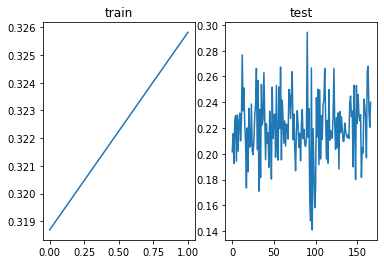

<Figure size 432x288 with 0 Axes>

 9830/50000 [===>.....................] - ETA: 2:37 - epoch: 2 - iter: 166 - step: 56000 - D loss: 1.3758 - D fake: 0.5977 - D real: 0.7781 - G loss: 4.9638 - G L1: 4.1649 - G gan: 0.7989 - accuracy: 0.3487
saving sample CIFAR10_DATASET_56000.png - learning rate: 1e-06
saving model...

18260/50000 [========>................] - ETA: 2:05 - epoch: 2 - iter: 308 - step: 56142 - D loss: 1.3757 - D fake: 0.5975 - D real: 0.7782 - G loss: 4.9775 - G L1: 4.1784 - G gan: 0.7991 - accuracy: 0.3473

In [ ]:
# Driver

# reset tensorflow graph
tf.reset_default_graph()
# initialize random seed
tf.set_random_seed(options["seed"])
np.random.seed(options["seed"])
random.seed(options["seed"])
# create a session environment
with tf.compat.v1.Session() as sess:
  if options["dataset"] == 'CIFAR10_DATASET':
    model = Cifar10Model(sess, options)

  elif options["dataset"] == 'PLACES365_DATASET':
    model = Places365Model(sess, options)

  if not os.path.exists(options["checkpoints_path"]):
    os.makedirs(options["checkpoints_path"])

  if options["log"]:
    open(model.train_log_file, 'w').close()
    open(model.test_log_file, 'w').close()
  # build the model and initialize
  model.build()
  sess.run(tf.global_variables_initializer())
  # load model only after global variables initialization
  model.load()
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  #summary(model, (3, 512,1024))
  print(model)

  if options["mode"] == 0:
    args = options
    print('\n------------ Options -------------')
    with open(os.path.join(options["checkpoints_path"], 'options.dat'), 'w') as f:
      for k, v in sorted(args.items()):
        print('%s: %s' % (str(k), str(v)))
        f.write('%s: %s\n' % (str(k), str(v)))
    print('-------------- End ----------------\n') 

    model.train()
      
  elif options["mode"] == 1:
      model.test()
  else:
      model.turing_test()
